# Memoris project

## Imports

#### Internal modules

In [1]:
from utils.io import dataframe_viewer
from utils.orm import orm_boreholes_from_dataframe
from utils.visual import legend_from_attributes, find_new_word_for_legend
from utils.config import DEFAULT_LITHO_LEXICON, DEFAULT_LITHO_LEGEND, DEFAULT_BOREHOLE_LEGEND, DEFAULT_POL_LEXICON

from core.project import Project
from definitions import ROOT_DIR

#### External modules

In [2]:
import os
import re
import pandas as pd
import pyvista as pv

## Reading of CSV files in a dir

In [3]:
data_dir = ROOT_DIR + '/CF_data/Result_traitem/fusion_finale/filtered/' 

In [4]:
litho_file = data_dir + 'Lithologies.csv'
sample_file = data_dir + 'Samples.csv'
bh_file = data_dir + 'Boreholes.csv'

In [5]:
litho = pd.read_csv(litho_file, sep=',')
sample = pd.read_csv(sample_file, sep=',')

In [6]:
dataframe_viewer(litho, rows=5, un_val='ID'), dataframe_viewer(sample, rows=5, un_val='ID')

Rows : 1890, columns : 11, Unique values on cols: {'ID': 397}


interactive(children=(IntSlider(value=5, description='rows', max=1890, min=5, readout=False), IntSlider(value=…

Rows : 1515, columns : 218, Unique values on cols: {'ID': 295}


interactive(children=(IntSlider(value=5, description='rows', max=1515, min=5, readout=False), IntSlider(value=…

(None, None)

In [7]:
litho.loc[1573, 'Litho_base'] = 4.5
litho['Type_ech'] = 'Sol'

### Keep data concerning Memoris site only

In [8]:
data_list = [litho, sample]
x_lim = (152804.75, 152921.12)
y_lim = (122545.08, 122667.38)
qry = f'X>={x_lim[0]} and X<={x_lim[1]} and Y>={y_lim[0]} and Y<={y_lim[1]}'

final_df = pd.DataFrame()
last_index = None
skip_cols = []
for dataf in data_list:
    assert isinstance(dataf, pd.DataFrame)
    df = dataf.query(qry).copy()

    # rename certain columns' name
    for col in df.columns:
        if col not in skip_cols:
            if re.search('top|toit', col, re.I):
                df.rename(columns={col: 'Top_intv'}, inplace=True)
            elif re.search('base|mur|assise', col, re.I):
                df.rename(columns={col: 'Base_intv'}, inplace=True)
            elif re.search('thick|epais', col, re.I):
                df.rename(columns={col: 'Thick_intv'}, inplace=True)
            elif re.search('descr', col, re.I):
                df.rename(columns={col: 'Descr_intv'}, inplace=True)

    if last_index is not None:
        df.index = range(last_index, last_index + len(df))

    final_df = final_df.append(df, ignore_index=True)
    last_index = len(final_df)
print(last_index, 'rows')

914 rows


In [9]:
memoris_site_data = final_df

### Rename boreholes by synonyms

In [10]:
from utils.io import dict_viewer, find_bh_synonyms, choose_bh_synonym, value_replication

In [11]:
syn_dict = find_bh_synonyms(memoris_site_data, regex_skip='bloqu|bis$|\d+[a-e]\'?M?$', dist_max=0.2, display=True)

42 possible synonyms found !


0,"['100', 'F100', 'F101']","[0, 1, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 648, 649, 650, 651, 652, 653]"
1,"['102', 'F102']","[2, 3, 154, 155, 156, 157, 158, 159, 160, 161, 654, 655, 656, 657, 658, 659, 660]"
2,"['103', 'F103']","[4, 5, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 661, 662, 663, 664, 665, 666, 667]"
3,"['104', 'F104']","[6, 173, 174, 668]"
4,"['105', 'F105']","[7, 8, 175, 176, 177, 178, 179, 180, 669, 670, 671, 672, 673, 674]"
5,"['108', 'F108']","[9, 10, 200, 201, 202, 203, 204, 205, 206, 207, 688, 689, 690, 691, 692]"
6,"['51', '52']","[95, 98, 101, 104, 107, 108, 109, 110, 111, 636, 639, 642, 645, 646, 647]"
7,"['536', 'F536']","[112, 113, 280, 281, 282, 283, 284, 285, 772]"
8,"['537', 'F537']","[114, 115, 286, 287, 288, 289, 773]"
9,"['76', 'F76']","[120, 310, 311, 312]"
10,"['78', 'F78']","[125, 328, 329]"


In [12]:
#choices = {63:'Mon3', 71:'_100_', 72:'_102_', 73:'_103_', 74:'_105_', 75:'_108_'}
memoris_site_data, syn_dict = choose_bh_synonym(memoris_site_data, syn_dict, regex_choice='^F|^P|^_F|^\d+$')#, choice_dict=choices)

All synonyms have been fixed !


In [13]:
crit_cols = ['ID','X','Y']
#pass_cols = crit_cols + ['Litho_top','Litho_base','Litho_epais','Description']
copy_cols = ['Type', 'Long_for', 'Diam_for'] #list(data.columns)
memoris_site_data = value_replication(memoris_site_data, crit_cols=crit_cols, pass_cols=None, copy_cols=copy_cols)

In [14]:
cols=['ID', 'Date_for', 'Diam_for', 'Long_for', 'top', 'base', 'Type', 'Descr_intv', 'ID_ech', 'Date_ech']
view_cols = []
for col in memoris_site_data.columns:
    for c in cols:
        if re.search(c, col, re.I):
            view_cols.append(col)

In [15]:
memoris_site_data = memoris_site_data.sort_values(['ID','Top_intv', 'Base_intv']).reset_index(drop=True)

In [16]:
bh_id='205'
dataframe_viewer(memoris_site_data.query(f"ID=='{bh_id}'")[view_cols], rows=12, cols=16)
#dataframe_viewer(memoris_site_data.query(f"ID=='{bh_id}'"), rows=10, cols=16)

Rows : 11, columns : 12


interactive(children=(IntSlider(value=11, description='rows', max=11, min=11, readout=False), IntSlider(value=…

## Create pollutants list from the dataframe columns name

In [17]:
pollutants = []
skipped = []
for i, c in enumerate(sample.columns):
    if c in DEFAULT_POL_LEXICON.abbreviations.keys() or c in DEFAULT_POL_LEXICON.abbreviations.values():
        #print(f"{i}: {c}")
        pollutants.append(c)
    else:
        skipped.append(c)
print(pollutants)

['Alp_C6-C8', 'CN_libre', 'Zn', 'Acenaphtn', 'Chloroforme', 'Acenaphtyl', 'Chrys', 'C35-C40', 'PCB_153', 'TCEyn', 'Toln', 'Ar_C7-C8', 'As', 'Bnz(ghi)peryl', 'MTBE', 'C10-C12', 'C16-C21', 'Alp_C8-C10', 'C12-C16', '1.1.2-TCE', 'Bnz(a)pyr', 'Ni', 'Cu', 'Trans-1.2-DCEyl', 'Hg', '(cis.trans)-1.2-DCEn_tot', 'Phenol', 'Alp_C5-C6', 'PCB_138', 'Naphta', 'Pb', 'DCM', 'Bnz', 'TCM', 'Indeno(1.2.3-cd)pyr', 'Phenanthr', 'C8-C10', 'CVinyl', 'CN_tot', 'Chlorure', 'PCB_28', 'Xyl', 'C5-C8', 'Dibnz(ah)anthrc', 'HAP_tot_EPA', '1.2-DCP', 'HC_tot_C10-C40', 'C21-C35', 'Cr_VI', '1.1-DCEn', 'PCB_tot', 'Styr', 'Cr', 'Pyr', 'Bnz(k)flranth', 'TetraCEyn', 'EOX', 'PCB_101', 'Bnz(a)anthrc', 'Ar_C8-C10', '1.1-DCE', 'Cd', 'PCB_52', '1.2-DCE', 'Co', 'Cis-1.2-DCEn', 'O-Xyl', 'BTEX_tot', 'Flranth', '1.1.1-TCE', 'S_tot', 'P-M-Xyl', 'HC_tot_C10-C35', 'PCB_180', 'Bnz(b)flranth', 'PCB_118', 'CN_cplx', 'Ar_C6-C7', 'Anthrc']


## Create Boreholes and components from dataframes

In [18]:
boreholes_orm, components_orm, link_intv_comp = orm_boreholes_from_dataframe(
                                                data_list=[memoris_site_data], default_z=102, id_col='ID', 
                                                bh_type_col='Type', date_col='Date_for', 
                                                length_col = 'Long_for', diameter_col='Diam_for',
                                                sample_type_col='Type_ech', sample_id_col='ID_ech',
                                                attributes=['lithology']+pollutants, 
                                                lexicons={'lithology':{'lexicon':DEFAULT_LITHO_LEXICON}}
                                                )


Data Processing...

 BH_ID: '201'
0- Interval top=0.0, base=2.4, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.6, base=1.2, components:1, first_component: {'lithology': 'remblais'}
2- Interval top=0.7, base=1.2, components:47, first_component: {'lithology': 'remblais'}
3- Interval top=1.2, base=2.4, components:1, first_component: {'lithology': 'caillasse'}
4- Interval top=2.0, base=2.4, components:47, first_component: {'lithology': 'remblais'}
Summary : {'201': Striplog(5 Intervals, start=0.0, stop=2.4)}

 BH_ID: '205'

0- Interval top=0.0, base=4.8, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.2, base=0.4, components:1, first_component: {'lithology': 'limon'}
2- Interval top=0.4, base=1.2, components:1, first_component: {'lithology': 'remblais'}
3- Interval top=1.2, base=2.4, components:1, first_component: {'lithology': 'remblais'}
4- Interval top=1.9, base=2.4, components:47, first_component: {'lithology': 'remblais'


0- Interval top=0.0, base=4.8, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.5, base=0.9, components:47, first_component: {'lithology': 'remblais'}
2- Interval top=1.0, base=1.2, components:1, first_component: {'lithology': 'remblais'}
3- Interval top=1.2, base=2.4, components:1, first_component: {'lithology': 'schistes'}
4- Interval top=1.8, base=2.3, components:47, first_component: {'lithology': 'remblais'}
5- Interval top=2.4, base=3.6, components:1, first_component: {'lithology': 'vide'}
6- Interval top=3.6, base=4.0, components:48, first_component: {'lithology': 'remblais'}
7- Interval top=4.0, base=4.8, components:1, first_component: {'lithology': 'limon'}
8- Interval top=4.2, base=4.6, components:46, first_component: {'cyanure_(libre)': 'vs', 'concentration': 1.0, 'unit': 'mg/kg MS'}
Summary : {'225': Striplog(9 Intervals, start=0.0, stop=4.8)}

 BH_ID: '226'


/home/yanathan/Projects/GSDMA/utils/utils.py:195: RuntimeWarning: All-NaN axis encountered
  spec_top, spec_base = 0, np.nanmax(df[length_col])
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/utils.py:195: RuntimeWarning: All-NaN axis encountered
  spec_top, spec_base = 0, np.nanmax(df[length_col])
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate 


0- Interval top=0.0, base=4.8, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.6, base=1.0, components:47, first_component: {'lithology': 'remblais'}
2- Interval top=1.0, base=1.2, components:1, first_component: {'lithology': 'limon'}
3- Interval top=1.2, base=2.4, components:1, first_component: {'lithology': 'remblais'}
4- Interval top=2.1, base=2.4, components:47, first_component: {'lithology': 'remblais'}
5- Interval top=2.4, base=3.2, components:1, first_component: {'lithology': 'remblais'}
6- Interval top=2.8, base=3.2, components:47, first_component: {'lithology': 'remblais'}
7- Interval top=3.2, base=3.6, components:1, first_component: {'lithology': 'limon'}
8- Interval top=3.6, base=4.8, components:1, first_component: {'lithology': 'limon'}
9- Interval top=3.8, base=4.3, components:46, first_component: {'cyanure_(libre)': 'vs', 'concentration': 1.0, 'unit': 'mg/kg MS'}
Summary : {'226': Striplog(10 Intervals, start=0.0, stop=4.8)}

 BH_ID: '301'


/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate


0- Interval top=0.0, base=3.6, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.5, base=0.7, components:1, first_component: {'lithology': 'remblais'}
2- Interval top=0.6, base=1.2, components:3, first_component: {'lithology': 'remblais'}
3- Interval top=0.7, base=1.2, components:181, first_component: {'lithology': 'remblais'}
4- Interval top=1.2, base=2.4, components:4, first_component: {'lithology': 'remblais'}
5- Interval top=1.8, base=2.4, components:45, first_component: {'lithology': 'remblais'}
6- Interval top=2.0, base=2.5, components:135, first_component: {'lithology': 'remblais'}
7- Interval top=2.4, base=3.6, components:3, first_component: {'lithology': 'caillasse'}
8- Interval top=3.0, base=3.6, components:180, first_component: {'lithology': 'remblais'}
Summary : {'51': Striplog(9 Intervals, start=0.0, stop=3.6)}

 BH_ID: '538a'
0- Interval top=0.0, base=3.6, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=3.0, base=

/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])


0- Interval top=0.0, base=5.5, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.1, base=0.2, components:1, first_component: {'lithology': 'brique'}
2- Interval top=0.2, base=0.7, components:33, first_component: {'lithology': 'scories'}
3- Interval top=0.4, base=0.6, components:1, first_component: {'lithology': 'remblais'}
4- Interval top=0.6, base=0.8, components:29, first_component: {'lithology': 'scories'}
5- Interval top=0.9, base=1.0, components:1, first_component: {'lithology': 'remblais'}
6- Interval top=1.0, base=1.6, components:1, first_component: {'lithology': 'brique'}
7- Interval top=1.2, base=1.5, components:33, first_component: {'lithology': 'remblais'}
8- Interval top=1.5, base=2.0, components:1, first_component: {'lithology': 'béton'}
9- Interval top=1.6, base=3.0, components:1, first_component: {'lithology': 'béton'}
10- Interval top=3.0, base=4.0, components:1, first_component: {'lithology': 'brique'}
11- Interval top=4.0, base=4.5, compon

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])


0- Interval top=0.0, base=2.0, components:2, first_component: {'borehole_type': 'borehole'}
1- Interval top=1.2, base=2.0, components:1, first_component: {'lithology': 'remblais'}
Summary : {'F10M': Striplog(2 Intervals, start=0.0, stop=2.0)}

 BH_ID: 'F11M'
0- Interval top=0.0, base=3.0, components:2, first_component: {'borehole_type': 'borehole'}
1- Interval top=1.2, base=3.0, components:2, first_component: {'lithology': 'remblais'}
Summary : {'F11M': Striplog(2 Intervals, start=0.0, stop=3.0)}

 BH_ID: 'F12M'
0- Interval top=0.0, base=4.8, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.2, base=0.5, components:2, first_component: {'lithology': 'remblais'}
2- Interval top=0.5, base=2.4, components:2, first_component: {'lithology': 'remblais'}
3- Interval top=0.7, base=1.2, components:92, first_component: {'lithology': 'remblais'}
4- Interval top=1.9, base=2.4, components:94, first_component: {'lithology': 'remblais'}
5- Interval top=2.4, base=3.6, compo

0- Interval top=0.0, base=4.8, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=2.0, base=2.4, components:35, first_component: {'lithology': 'remblais'}
2- Interval top=3.5, base=4.0, components:35, first_component: {'lithology': 'remblais'}
3- Interval top=3.8, base=4.8, components:1, first_component: {'lithology': 'alluvions'}
Summary : {'F22M': Striplog(4 Intervals, start=0.0, stop=4.8)}

 BH_ID: 'F23M'
0- Interval top=0.0, base=3.6, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.3, base=0.8, components:70, first_component: {'lithology': 'remblais'}
2- Interval top=3.1, base=3.5, components:70, first_component: {'lithology': 'remblais'}
3- Interval top=3.5, base=3.6, components:1, first_component: {'lithology': 'alluvions'}
Summary : {'F23M': Striplog(4 Intervals, start=0.0, stop=3.6)}

 BH_ID: 'F24a'
0- Interval top=0.0, base=1.0, components:2, first_component: {'borehole_type': 'borehole'}
Summary : {'F24a': Striplog(1 In

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])


0- Interval top=0.0, base=6.0, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=1.8, base=2.2, components:70, first_component: {'lithology': 'remblais'}
2- Interval top=3.1, base=3.6, components:70, first_component: {'lithology': 'remblais'}
3- Interval top=3.7, base=6.0, components:1, first_component: {'lithology': 'alluvions'}
4- Interval top=3.8, base=4.3, components:70, first_component: {'lithology': 'limons'}
5- Interval top=5.6, base=6.0, components:70, first_component: {'lithology': 'limons'}
Summary : {'F26M': Striplog(6 Intervals, start=0.0, stop=6.0)}

 BH_ID: 'F27A'
0- Interval top=0.0, base=0.8, components:2, first_component: {'borehole_type': 'borehole'}
Summary : {'F27A': Striplog(1 Intervals, start=0.0, stop=0.8)}
No diameter value found for F27A, using default: 0.1

 BH_ID: 'F27b'
0- Interval top=0.0, base=0.4, components:2, first_component: {'borehole_type': 'borehole'}
Summary : {'F27b': Striplog(1 Intervals, start=0.0, stop=0.4)}
No diamet

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA


3- Interval top=2.2, base=2.6, components:35, first_component: {'lithology': 'ballasts'}
4- Interval top=3.0, base=3.6, components:1, first_component: {'lithology': 'limon'}
5- Interval top=3.2, base=3.6, components:35, first_component: {'lithology': 'limon'}
Summary : {'F538': Striplog(6 Intervals, start=0.0, stop=3.6)}
No diameter value found for F538, using default: 0.1

 BH_ID: 'F5M'
0- Interval top=0.0, base=6.0, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.5, base=3.8, components:1, first_component: {'lithology': 'remblais'}
2- Interval top=3.8, base=4.2, components:48, first_component: {'lithology': 'remblais limons'}
3- Interval top=4.0, base=6.0, components:1, first_component: {'lithology': 'alluvions'}
4- Interval top=4.2, base=6.0, components:1, first_component: {'lithology': 'limons'}
5- Interval top=5.8, base=6.0, components:47, first_component: {'lithology': 'limons'}
Summary : {'F5M': Striplog(6 Intervals, start=0.0, stop=6.0)}

 BH_ID:


 BH_ID: 'F81'

0- Interval top=0.0, base=6.4, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.2, base=0.5, components:29, first_component: {'lithology': 'scories'}
2- Interval top=0.5, base=1.5, components:1, first_component: {'lithology': 'remblais'}
3- Interval top=1.0, base=1.5, components:28, first_component: {'cyanure_(libre)': 'vs', 'concentration': 1.0, 'unit': 'mg/kg MS'}
4- Interval top=1.5, base=1.8, components:1, first_component: {'lithology': 'béton'}
5- Interval top=1.8, base=4.0, components:1, first_component: {'lithology': 'remblais'}
6- Interval top=2.0, base=2.5, components:29, first_component: {'lithology': 'argile'}
7- Interval top=3.5, base=4.0, components:1, first_component: {'lithology': 'argile'}
8- Interval top=4.0, base=4.3, components:1, first_component: {'lithology': 'remblais'}
9- Interval top=4.3, base=4.5, components:1, first_component: {'lithology': 'remblais'}
10- Interval top=4.5, base=5.2, components:1, first_component: 

0- Interval top=0.0, base=2.5, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.2, base=0.7, components:33, first_component: {'cyanure_(libre)': 'vs', 'concentration': 1.0, 'unit': 'mg/kg MS'}
2- Interval top=0.7, base=1.7, components:1, first_component: {'lithology': 'remblais'}
3- Interval top=1.2, base=1.7, components:1, first_component: {'lithology': 'scories'}
4- Interval top=1.7, base=3.4, components:1, first_component: {'lithology': 'remblais'}
5- Interval top=2.1, base=2.6, components:33, first_component: {'lithology': 'sable'}
6- Interval top=3.4, base=5.0, components:1, first_component: {'lithology': 'remblais'}
7- Interval top=4.0, base=4.5, components:33, first_component: {'lithology': 'graviers'}
8- Interval top=5.0, base=6.6, components:1, first_component: {'lithology': 'limon'}
9- Interval top=6.6, base=8.0, components:1, first_component: {'lithology': 'limon'}
10- Interval top=7.0, base=7.5, components:31, first_component: {'lithology': 'ar

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])


0- Interval top=0.0, base=4.8, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.5, base=2.0, components:1, first_component: {'lithology': 'scories charbon'}
2- Interval top=2.0, base=3.0, components:1, first_component: {'lithology': 'graviers'}
3- Interval top=3.0, base=3.6, components:26, first_component: {'lithology': 'graviers'}
4- Interval top=3.6, base=4.2, components:1, first_component: {'lithology': 'gravier'}
5- Interval top=4.2, base=4.6, components:1, first_component: {'lithology': 'limon'}
6- Interval top=4.6, base=4.8, components:1, first_component: {'lithology': 'limon'}
7- Interval top=4.7, base=4.8, components:32, first_component: {'lithology': 'limons'}
Summary : {'Mon3': Striplog(8 Intervals, start=0.0, stop=4.8)}
No diameter value found for Mon3, using default: 0.1

 BH_ID: 'P15a'M'
0- Interval top=0.0, base=0.5, components:2, first_component: {'borehole_type': 'borehole'}
Summary : {"P15a'M": Striplog(1 Intervals, start=0.0, stop=0.5)}
N

/home/yanathan/Projects/GSDMA/utils/utils.py:195: RuntimeWarning: All-NaN axis encountered
  spec_top, spec_base = 0, np.nanmax(df[length_col])
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)


0- Interval top=0.0, base=1.0, components:1, first_component: {'borehole_type': 'borehole'}
1- Interval top=0.2, base=0.5, components:1, first_component: {'lithology': 'béton'}
2- Interval top=0.5, base=1.2, components:1, first_component: {'lithology': 'béton'}
3- Interval top=1.2, base=2.0, components:1, first_component: {'lithology': 'remblais'}
4- Interval top=2.0, base=2.5, components:1, first_component: {'lithology': 'scories'}
5- Interval top=2.7, base=3.7, components:1, first_component: {'lithology': 'remblais'}
6- Interval top=3.0, base=3.5, components:35, first_component: {'lithology': 'scories'}
7- Interval top=3.7, base=6.0, components:1, first_component: {'lithology': 'limon'}
8- Interval top=4.5, base=5.0, components:35, first_component: {'lithology': 'argile'}
9- Interval top=5.5, base=6.0, components:35, first_component: {'lithology': 'argile'}
10- Interval top=6.0, base=6.9, components:1, first_component: {'lithology': 'limon'}
11- Interval top=6.3, base=6.8, components

/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/interval.py:100: UserWarning: You must provide a lexicon to generate components from descriptions.
  warnings.warn(w)
/home/yanathan/Projects/GSDMA/utils/orm.py:350: RuntimeWarning: All-NaN axis encountered
  diam_val = np.nanmax(tmp[diameter_col])


In [19]:
len(boreholes_orm), len(components_orm)

(132, 59)

In [20]:
boreholes_orm # list of core.BoreholeOrm objects

[<core.orm.BoreholeOrm>(id=201, type=Piezo, length=2.4, diameter=0.075, intervals=5),
 <core.orm.BoreholeOrm>(id=205, type=Forage, length=4.8, diameter=0.075, intervals=9),
 <core.orm.BoreholeOrm>(id=207, type=Piezo, length=4.8, diameter=0.075, intervals=11),
 <core.orm.BoreholeOrm>(id=208, type=Piezo, length=4.8, diameter=0.075, intervals=9),
 <core.orm.BoreholeOrm>(id=212, type=Forage, length=4.8, diameter=0.075, intervals=8),
 <core.orm.BoreholeOrm>(id=214, type=Piezo, length=4.8, diameter=0.075, intervals=10),
 <core.orm.BoreholeOrm>(id=217, type=Forage, length=4.8, diameter=0.075, intervals=8),
 <core.orm.BoreholeOrm>(id=219, type=Piezo, length=1.5, diameter=0.075, intervals=3),
 <core.orm.BoreholeOrm>(id=220, type=Piezo, length=0.5, diameter=0.075, intervals=1),
 <core.orm.BoreholeOrm>(id=221, type=Piezo, length=1.4, diameter=0.075, intervals=3),
 <core.orm.BoreholeOrm>(id=223, type=Piezo, length=1.3, diameter=0.1, intervals=2),
 <core.orm.BoreholeOrm>(id=224, type=Forage, length

In [21]:
components_orm # dict of striplog.Component objects

{0: <core.orm.ComponentOrm>(id=0, description={'borehole_type': 'Piezo'}),
 1: <core.orm.ComponentOrm>(id=1, description={'lithology': 'remblai'}),
 2: <core.orm.ComponentOrm>(id=2, description={'pollutant': 'zinc'}),
 3: <core.orm.ComponentOrm>(id=3, description={'pollutant': 'acénaphtène'}),
 4: <core.orm.ComponentOrm>(id=4, description={'pollutant': 'chloroforme'}),
 5: <core.orm.ComponentOrm>(id=5, description={'pollutant': 'acénaphtylène'}),
 6: <core.orm.ComponentOrm>(id=6, description={'pollutant': 'chrysène'}),
 7: <core.orm.ComponentOrm>(id=7, description={'pollutant': 'trichloroéthylène'}),
 8: <core.orm.ComponentOrm>(id=8, description={'pollutant': 'toluène'}),
 9: <core.orm.ComponentOrm>(id=9, description={'pollutant': 'arsenic'}),
 10: <core.orm.ComponentOrm>(id=10, description={'pollutant': 'benzo(ghi)pérylène'}),
 11: <core.orm.ComponentOrm>(id=11, description={'pollutant': 'mtbe'}),
 12: <core.orm.ComponentOrm>(id=12, description={'pollutant': '1.1.2-trichloroéthane'}),

In [22]:
link_intv_comp

{(0, 0): {'extra_data': None},
 (1, 1): {'extra_data': None},
 (2, 1): {'extra_data': None},
 (2,
  2): {'extra_data': "{'level': 'vs', 'concentration': 210.0, 'unit': 'mg/kg MS'}"},
 (2,
  3): {'extra_data': "{'level': 'vs', 'concentration': 1.3, 'unit': 'mg/kg MS'}"},
 (2,
  4): {'extra_data': "{'level': 'vr', 'concentration': 0.02, 'unit': 'mg/kg MS'}"},
 (2,
  5): {'extra_data': "{'level': 'vs', 'concentration': 1.7, 'unit': 'mg/kg MS'}"},
 (2,
  6): {'extra_data': "{'level': 'vs', 'concentration': 2.6, 'unit': 'mg/kg MS'}"},
 (2,
  7): {'extra_data': "{'level': 'vr', 'concentration': 0.02, 'unit': 'mg/kg MS'}"},
 (2,
  8): {'extra_data': "{'level': 'vs', 'concentration': 0.59, 'unit': 'mg/kg MS'}"},
 (2,
  9): {'extra_data': "{'level': 'vr', 'concentration': 11.0, 'unit': 'mg/kg MS'}"},
 (2,
  10): {'extra_data': "{'level': 'vs', 'concentration': 2.2, 'unit': 'mg/kg MS'}"},
 (2,
  11): {'extra_data': "{'level': 'vr', 'concentration': 0.05, 'unit': 'mg/kg MS'}"},
 (2,
  12): {'extr

## Create a dictionary containing legends for each representation attribute

In [23]:
legend_dict = legend_from_attributes([('borehole_type', DEFAULT_BOREHOLE_LEGEND), 
                                      ('lithology', DEFAULT_LITHO_LEGEND)] + pollutants)

## create a project

In [24]:
p = Project.load(db_name='../tmp_files/Memoris_project', legend_dict=legend_dict, lexicon=DEFAULT_LITHO_LEXICON, 
                 auto_erase_db=True)

Database file found and erased! Creation of a new project ...


### Insert boreholes and components into the project

In [25]:
p.add_components(components_orm)

In [26]:
for bhorm in boreholes_orm:
    p.add_borehole(bhorm)

In [27]:
p.add_link_components_intervals(link_intv_comp)

### Validate modifications 

In [28]:
p.commit()

In [29]:
p.refresh(update_3d=True, update_legend=True)

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


In [30]:
p.session.close()

## Visualization

### Localization of project boreholes

In [31]:
p.plot_map()

## Plot a log for one specific borehole, according to the representation attribute

In [32]:
attributes = list(legend_dict.keys())
print(attributes)

['borehole_type', 'lithology', 'fraction aliphat. >c6-c8', 'cyanure (libre)', 'zinc', 'acénaphtène', 'chloroforme', 'acénaphtylène', 'chrysène', 'fraction c35-c40', 'pcb 153', 'trichloroéthylène', 'toluène', 'fraction aromat. >c7-c8', 'arsenic', 'benzo(ghi)pérylène', 'mtbe', 'fraction c10-c12', 'fraction c16-c21', 'fraction aliphat. >c8-c10', 'fraction c12-c16', '1.1.2-trichloroéthane', 'benzo(a)pyrène', 'nickel', 'cuivre', 'trans 1.2-dichloroéthylène', 'mercure', 'totaux (cis.trans) 1.2-dichloroéthène', 'phénol', 'fraction aliphat. c5-c6', 'pcb 138', 'naphtalène', 'plomb', 'dichlorométhane', 'benzène', 'tétrachlorométhane', 'indéno(1.2.3-cd)pyrène', 'phénanthrène', 'fraction c8-c10', 'chlorure de vinyle', 'cyanure (totaux)', 'chlorure', 'pcb 28', 'xylène', 'fraction c5-c8', 'dibenzo(ah)anthracène', 'hap totaux - epa', '1.2-dichloropropane', 'hydrocarbures totaux c10-c40', 'fraction c21-c35', 'chrome vi', '1.1-dichloroéthène', 'pcb totaux', 'styrène', 'chrome', 'pyrène', 'benzo(k)fluor

In [33]:
n = 'lithology' #'borehole_type'
if isinstance(n, str):
    n = attributes.index(n)

print('Chosen attribute is :', attributes[n])
p.repr_attribute = attributes[n]

Chosen attribute is : lithology


/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


In [34]:
p.attrib_legend

Legend(Decor({'_colour': '#8f4d31', 'width': 3, 'hatch': 'x..', 'component': Component({'lithology': 'remblai'})})
Decor({'_colour': '#bc8d78', 'width': 3, 'hatch': 'o-o', 'component': Component({'lithology': 'caillasse'})})
Decor({'_colour': '#bccfed', 'width': 3, 'hatch': '-.', 'component': Component({'lithology': 'limon'})})
Decor({'_colour': '#a607ef', 'width': 3, 'hatch': '....', 'component': Component({'lithology': 'alluvion'})})
Decor({'_colour': '#b2e965', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'brique'})})
Decor({'_colour': '#5d4e31', 'width': 3, 'hatch': '--', 'component': Component({'lithology': 'schiste'})})
Decor({'_colour': '#ffffff', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'vide'})})
Decor({'_colour': '#154157', 'width': 3, 'hatch': 'xxx', 'component': Component({'lithology': 'scorie'})})
Decor({'_colour': '#ec809a', 'width': 3, 'hatch': 'ox', 'component': Component({'lithology': 'béton'})})
Decor({'_colour': '#cf302a', 'width': 3, 'hatch': '---', 'component': Component({'lithology': 'argile'})})
Decor({'_colour': '#7a928d', 'width': 3, 'hatch': '..', 'component': Component({'lithology': 'sable'})})
Decor({'_colour': '#98b71a', 'width': 3, 'hatch': 'oo', 'component': Component({'lithology': 'gravier'})})
Decor({'_colour': '#fdd53e', 'width': 3, 'hatch': 'xxx', 'component': Component({'lithology': 'laitier'})}))

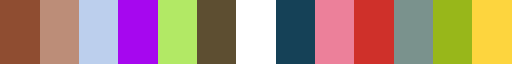

In [35]:
p.attrib_cmap

In [36]:
print(p.attrib_values)

['remblai', 'caillasse', 'limon', 'alluvion', 'brique', 'scories laitier', 'schiste', 'vide', 'scorie', 'béton', 'argile', 'sable', 'gravier', 'laitier', 'ballast', 'béton scorie', 'béton brique', 'scories charbon']


In [37]:
find_new_word_for_legend(p.legend_dict, p.repr_attribute)

['scories laitier',
 'ballast',
 'béton scorie',
 'béton brique',
 'scories charbon']

### Borehole log

In [38]:
bh_name = '205'

Attribute: 'lithology'



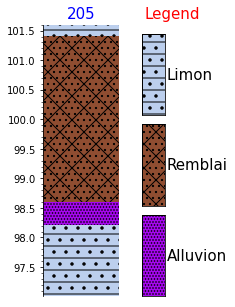

In [39]:
ticks=(0.1, 0.5)
p.plot_log(bh_name=bh_name, ticks=ticks)

In [44]:
p.boreholes_3d[bh_name].attrib_components()

{0: Component({'lithology': 'limon'}),
 1: Component({'lithology': 'remblai'}),
 2: Component({'lithology': 'remblai'}),
 3: Component({'lithology': 'remblai'}),
 4: Component({'lithology': 'remblai'}),
 5: Component({'lithology': 'remblai'}),
 6: Component({'lithology': 'alluvion'}),
 7: Component({'lithology': 'limon'})}

In [50]:
p.boreholes_3d[bh_name]._vtk.__class__

pyvista.core.pointset.PolyData

In [45]:
p.boreholes_3d[bh_name].components

{0: [Component({'lithology': 'limon'})],
 1: [Component({'lithology': 'remblai'})],
 2: [Component({'lithology': 'remblai'})],
 3: [Component({'lithology': 'remblai'}),
  Component({'pollutant': 'zinc', 'level': 'vi', 'concentration': 550.0, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'acénaphtène', 'level': 'vi', 'concentration': 54.0, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'chloroforme', 'level': 'vr', 'concentration': 0.02, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'acénaphtylène', 'level': 'vs', 'concentration': 4.5, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'chrysène', 'level': 'vs', 'concentration': 1.1, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'trichloroéthylène', 'level': 'vr', 'concentration': 0.02, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'toluène', 'level': 'vs', 'concentration': 1.5, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'arsenic', 'level': 'vs', 'concentration': 13.0, 'unit': 'mg/kg MS'}),
  Component({'pollutant': 'benzo(gh

#### add ground surface to the plotter

In [41]:
other_vtks = {'ground_surface':{'mesh':pv.read('../20211122/ground_surface.vtk'),
                                'color':'green', 
                                'opacity':0.2}}

* Change repr_attribute

In [42]:
n = 'arsenic'
if isinstance(n, str):
    n = attributes.index(n)

print('Chosen attribute is :', attributes[n])
p.repr_attribute = attributes[n]

Chosen attribute is : arsenic


Attribute: 'arsenic'



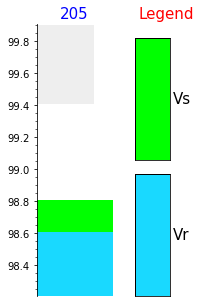

In [43]:
ticks=(0.05, 0.2)
p.plot_log(bh_name=bh_name, ticks=ticks)

In [44]:
p.boreholes_3d[bh_name]#.attrib_components()

<core.visual.Borehole3D> name: 205 | length:1.70 m | 3 Intervals | start=99.90, stop=98.20

In [45]:
p.attrib_legend

Legend(Decor({'_colour': '#19d9ff', 'width': 3, 'component': Component({'level': 'vr'}), 'hatch': None})
Decor({'_colour': '#00ff00', 'width': 3, 'component': Component({'level': 'vs'}), 'hatch': None})
Decor({'_colour': '#ffa500', 'width': 3, 'component': Component({'level': 'vi'}), 'hatch': None}))

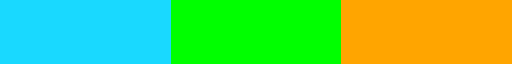

In [46]:
p.attrib_cmap

In [47]:
p.repr_attribute

'arsenic'

In [48]:
p.boreholes_3d[bh_name].attrib_components()

{0: Component({'pollutant': 'arsenic', 'level': 'vs', 'concentration': 13.0, 'unit': 'mg/kg MS'}),
 1: Component({'pollutant': 'arsenic', 'level': 'vr', 'concentration': 7.0, 'unit': 'mg/kg MS'}),
 2: Component({'pollutant': 'arsenic', 'level': 'vr', 'concentration': 10.0, 'unit': 'mg/kg MS'})}

In [49]:
p.attrib_values

['vr', 'vs', 'vi']

Attribute: 'arsenic'



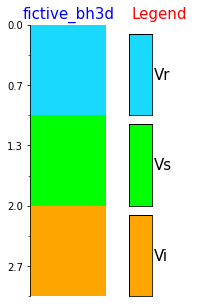

In [50]:
p.__fictive_bh3d__.plot_log()

In [51]:
bg_color = 'w'#["royalblue", "aliceblue"] #'white'
p.plot_3d(bh_name_size=10, legend_title_size=25, legend_label_size=6, legend_vertical=True, 
          bg_color=bg_color, window_size=(800, 600), diam=0.2, smooth_shading=True,
         add_vtks_obj=other_vtks)#, verbose=True)#, jupyter_backend='panel', verbose=False)

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


adding ground_surface ...


### 3D display of project's boreholes

### 3D display of one borehole